In [1]:
!nvidia-smi

Wed May 27 09:07:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   26C    P8    14W / 250W |  10710MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   24C    P8     5W / 250W |  10831MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
neg_path = load_path('train', 'n', 'neg', data = 'sm_x160')
redspot_path = load_path('train', 'h', 'redspot', data = 'sm_x160')
angio_path = load_path('train', 'h', 'angio', data = 'sm_x160')
active_path = load_path('train', 'h', 'active', data = 'sm_x160')
# ero_path = load_path('train', 'd', 'ero', data = 'sm_x160')
# ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm_x160')
# str_path = load_path('train', 'd', 'str', data = 'sm_x160')

print("negative:",neg_path.shape)
print("red spot:",redspot_path.shape)
print("angioectasia:",angio_path.shape)
print("active_bleeding:",active_path.shape)
# print("erosion:",ero_path.shape)
# print("ulcer:",ulcer_path.shape)
# print("stricture:",str_path.shape)

negative: (1017120,)
red spot: (92960,)
angioectasia: (3200,)
active_bleeding: (66240,)


In [18]:
neg_path

array(['/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_-.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_ab.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_mb.jpg',
       ...,
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/sK___04-38-46___2050552__c_f_-_-.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/sK___04-52-52___2052244__c_-_-_-.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/현서___00-22-27___2007023__nodularities 로 기재되어 있는데, 사진이 ulcer 처럼 보여서...__c_f_-_-.jpg'],
      dtype='<U178')

In [4]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
angio_train_path, angio_valid_path = train_valid_split(angio_path)
active_train_path, active_valid_path = train_valid_split(active_path)
# ero_train_path, ero_valid_path = train_valid_split(ero_path)
# ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
# str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
print("active bleeding:", active_train_path.shape, active_valid_path.shape)
# print("erosion:", ero_train_path.shape, ero_valid_path.shape)
# print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
# print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (864552,) (129653,)
red spot: (79016,) (11832,)
angioectasia: (2720,) (417,)
active bleeding: (56304,) (8492,)


# Model

In [5]:
input_h = 512
input_w = 512
input_ch = 3

k_chs = [16, 16, 16, 32, 32, 32, 64]
n_conv_block = len(k_chs)
n_hid_node = [100, 50]
n_hid_layer = len(n_hid_node)
n_output = 2

In [6]:
class CE_cnn:
    def __init__(self, k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output):
        self.k_chs = k_chs
        self.n_conv_block = n_conv_block
        self.n_hid_node = n_hid_node
        self.n_hid_layer = n_hid_layer
        self.n_output = n_output
    def conv_block(self, x, k_chs, n_conv_block):
        for i in range(1, n_conv_block + 1):
            if i == 1:
                conv = tf.layers.conv2d(inputs = x, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            else:
                conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                    activation= tf.nn.relu, name = 'block_{}_conv_2'.format(i))
            conv = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2, name = 'block_{}_maxp'.format(i))
        return conv
    def fc_layers(self, x, n_hid_node, n_hid_layer, n_output):
        hidden = tf.layers.flatten(x)
        for i in range(1, n_hid_layer + 1):
            hidden = tf.layers.dense(inputs = hidden, units = n_hid_node[i-1],activation = tf.nn.relu, name = 'fc_{}'.format(i))
            hidden = tf.layers.dropout(hidden, rate = 0.3, training = is_training)
        score = tf.layers.dense(inputs = hidden, units = n_output, name = 'score')
        return score
    
    def inf(self, x):
        conv = self.conv_block(x, self.k_chs, self.n_conv_block)
        score = self.fc_layers(conv, self.n_hid_node, self.n_hid_layer, self.n_output)
        return score

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')
LR = tf.placeholder(tf.float32)

model = CE_cnn(k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0527 09:08:07.919760 140239249594112 deprecation.py:323] From <ipython-input-6-147423120551>:12: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0527 09:08:07.923841 140239249594112 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0527 09:08:08.111175 140239249594112 deprecation.py:323] From <ipython-input-6-147423120551>:18: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0527 09:08:08.384644 140239249594112 deprecation.py:323] F

# Training

damped_exp_LR(30000, alpha = 0.00005) <br>
n_batch (per class) = 50  <br>
cal_interval = 10 <br>
prt_interval = 100 <br>

In [8]:
h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = shuffle(h_train_path, None)
a_valid_path = shuffle(h_valid_path, None)

In [9]:
damped_exp_LR

<function ce_utils.damped_exp_LR(n_iter, f=20, A=0.0005, alpha=0.0002, gamma=0.1)>

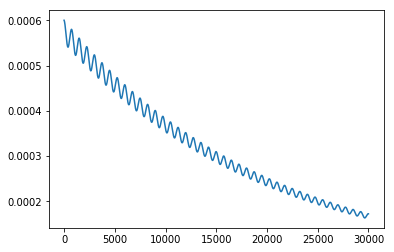

In [10]:
D_lr = damped_exp_LR(30000, alpha = 0.00005)

plt.plot(D_lr)

## training negative images: 254,280 (x40)

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/x160_rev/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 50.00 %    || 51.00 %    || 0.69030029 || 0.69175822
--------------------------------------------------------------
[*200] || 68.00 %    || 72.00 %    || 0.56495476 || 0.55371737
--------------------------------------------------------------


W0527 09:12:50.592128 140239249594112 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*300] || 68.00 %    || 75.00 %    || 0.57966584 || 0.51137429
--------------------------------------------------------------
[*400] || 81.00 %    || 81.00 %    || 0.40191209 || 0.42564449
--------------------------------------------------------------
[*500] || 75.00 %    || 76.00 %    || 0.45104846 || 0.48228031
--------------------------------------------------------------
[*600] || 85.00 %    || 87.00 %    || 0.35819167 || 0.37370908
--------------------------------------------------------------
[*700] || 92.00 %    || 85.00 %    || 0.26558253 || 0.36962464
--------------------------------------------------------------
[*800] || 90.00 %    || 86.00 %    || 0.26756155 || 0.31963381
--------------------------------------------------------------
[*900] || 97.00 %    || 92.00 %    || 0.17426121 || 0.23878348
--------------------------------------------------------------
[1000] || 93.00 %    || 92.00 %    || 0.17739119 || 0.21010286
-------------------------------------------------------

[6800] || 99.00 %    || 95.00 %    || 0.03804284 || 0.12380832
--------------------------------------------------------------
[6900] || 99.00 %    || 98.00 %    || 0.04683641 || 0.07915644
--------------------------------------------------------------
[7000] || 98.00 %    || 96.00 %    || 0.09362129 || 0.09941383
--------------------------------------------------------------
[7100] || 95.00 %    || 98.00 %    || 0.11082717 || 0.09071065
--------------------------------------------------------------
[7200] || 99.00 %    || 100.00 %    || 0.03451788 || 0.03106921
--------------------------------------------------------------
[7300] || 99.00 %    || 98.00 %    || 0.03804614 || 0.04160195
--------------------------------------------------------------
[7400] || 95.00 %    || 97.00 %    || 0.15567715 || 0.05184470
--------------------------------------------------------------
[7500] || 95.00 %    || 96.00 %    || 0.09158474 || 0.10817797
------------------------------------------------------

[13300] || 99.00 %    || 98.00 %    || 0.02379368 || 0.04587352
--------------------------------------------------------------
[13400] || 99.00 %    || 98.00 %    || 0.03154028 || 0.04613018
--------------------------------------------------------------
[13500] || 100.00 %    || 98.00 %    || 0.00635461 || 0.07497123
--------------------------------------------------------------
[13600] || 99.00 %    || 95.00 %    || 0.03265977 || 0.07030508
--------------------------------------------------------------
[13700] || 99.00 %    || 99.00 %    || 0.02253981 || 0.06365320
--------------------------------------------------------------
[13800] || 100.00 %    || 99.00 %    || 0.01729441 || 0.01197537
--------------------------------------------------------------
[13900] || 100.00 %    || 98.00 %    || 0.02350778 || 0.03828248
--------------------------------------------------------------
[14000] || 97.00 %    || 99.00 %    || 0.03916538 || 0.05394263
--------------------------------------------

[19800] || 99.00 %    || 99.00 %    || 0.02112813 || 0.02772180
--------------------------------------------------------------
[19900] || 99.00 %    || 98.00 %    || 0.01236602 || 0.03149331
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00553107 || 0.01331252
--------------------------------------------------------------
[20100] || 99.00 %    || 98.00 %    || 0.01453455 || 0.05607490
--------------------------------------------------------------
[20200] || 98.00 %    || 99.00 %    || 0.03233245 || 0.01589759
--------------------------------------------------------------
[20300] || 99.00 %    || 95.00 %    || 0.03100462 || 0.15644723
--------------------------------------------------------------
[20400] || 100.00 %    || 99.00 %    || 0.00320504 || 0.02047151
--------------------------------------------------------------
[20500] || 100.00 %    || 100.00 %    || 0.00769829 || 0.00564587
------------------------------------------

[26200] || 100.00 %    || 100.00 %    || 0.00760862 || 0.00378569
--------------------------------------------------------------
[26300] || 100.00 %    || 100.00 %    || 0.00129651 || 0.00285639
--------------------------------------------------------------
[26400] || 99.00 %    || 100.00 %    || 0.01190536 || 0.00718083
--------------------------------------------------------------
[26500] || 99.00 %    || 100.00 %    || 0.02754571 || 0.00638716
--------------------------------------------------------------
[26600] || 100.00 %    || 99.00 %    || 0.00181552 || 0.01029063
--------------------------------------------------------------
[26700] || 100.00 %    || 100.00 %    || 0.00445844 || 0.00110872
--------------------------------------------------------------
[26800] || 100.00 %    || 100.00 %    || 0.00344021 || 0.00188409
--------------------------------------------------------------
[26900] || 100.00 %    || 99.00 %    || 0.00532241 || 0.01715579
-----------------------------------

## training negative images: 50,856 (x8)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 67.00 %    || 77.00 %    || 0.62361163 || 0.54463470
--------------------------------------------------------------
[*200] || 92.00 %    || 87.00 %    || 0.23708546 || 0.37606373
--------------------------------------------------------------
[*300] || 94.00 %    || 89.00 %    || 0.16151376 || 0.30991933
--------------------------------------------------------------
[*400] || 98.00 %    || 96.00 %    || 0.03685898 || 0.14564519
--------------------------------------------------------------
[*500] || 93.00 %    || 96.00 %    || 0.16610405 || 0.20766741
--------------------------------------------------------------
[*600] || 94.00 %    || 93.00 %    || 0.13522221 || 0.21029112
--------------------------------------------------------------
[*700] || 98.00 %    || 97.00 %    || 0.05793071 || 0.11590753
--------------------------------------------------------------
[*800] || 99.00 %    || 95.00 %    || 0.02764449 || 0.2

[6500] || 100.00 %    || 98.00 %    || 0.00000000 || 1.03358305
--------------------------------------------------------------
[6600] || 100.00 %    || 98.00 %    || 0.00000000 || 0.64641100
--------------------------------------------------------------
[6700] || 100.00 %    || 96.00 %    || 0.00000001 || 0.65582275
--------------------------------------------------------------
[6800] || 100.00 %    || 94.00 %    || 0.00000000 || 2.08545709
--------------------------------------------------------------
[6900] || 100.00 %    || 99.00 %    || 0.00000000 || 0.89271516
--------------------------------------------------------------
[7000] || 100.00 %    || 96.00 %    || 0.00000000 || 1.49181783
--------------------------------------------------------------
[7100] || 100.00 %    || 96.00 %    || 0.00000001 || 1.26301837
--------------------------------------------------------------
[7200] || 100.00 %    || 97.00 %    || 0.00000001 || 0.91472852
-----------------------------------------------

[13000] || 100.00 %    || 97.00 %    || 0.00000000 || 2.23548508
--------------------------------------------------------------
[13100] || 100.00 %    || 97.00 %    || 0.00000000 || 1.72529054
--------------------------------------------------------------
[13200] || 100.00 %    || 98.00 %    || 0.00000000 || 0.94556105
--------------------------------------------------------------
[13300] || 100.00 %    || 98.00 %    || 0.00000000 || 1.36326098
--------------------------------------------------------------
[13400] || 100.00 %    || 93.00 %    || 0.00000000 || 4.37926435
--------------------------------------------------------------
[13500] || 100.00 %    || 99.00 %    || 0.00000000 || 0.13923167
--------------------------------------------------------------
[13600] || 100.00 %    || 91.00 %    || 0.00000000 || 5.16769457
--------------------------------------------------------------
[13700] || 100.00 %    || 93.00 %    || 0.00000000 || 4.90493155
---------------------------------------

[19500] || 100.00 %    || 96.00 %    || 0.00000000 || 0.97128016
--------------------------------------------------------------
[19600] || 100.00 %    || 95.00 %    || 0.00000000 || 0.63541198
--------------------------------------------------------------
[19700] || 100.00 %    || 96.00 %    || 0.00000000 || 0.59669310
--------------------------------------------------------------
[19800] || 100.00 %    || 95.00 %    || 0.00000000 || 0.70830339
--------------------------------------------------------------
[19900] || 100.00 %    || 94.00 %    || 0.00000000 || 1.38600576
--------------------------------------------------------------
[20000] || 100.00 %    || 95.00 %    || 0.00000000 || 1.20162952
--------------------------------------------------------------
[20100] || 100.00 %    || 94.00 %    || 0.00000000 || 1.71694231
--------------------------------------------------------------
[20200] || 100.00 %    || 95.00 %    || 0.00000000 || 0.97308332
---------------------------------------

[26000] || 100.00 %    || 96.00 %    || 0.00000003 || 0.53198355
--------------------------------------------------------------
[26100] || 100.00 %    || 94.00 %    || 0.00000001 || 1.82421052
--------------------------------------------------------------
[26200] || 100.00 %    || 95.00 %    || 0.00000001 || 0.78526467
--------------------------------------------------------------
[26300] || 100.00 %    || 93.00 %    || 0.00000002 || 2.13219547
--------------------------------------------------------------
[26400] || 100.00 %    || 94.00 %    || 0.00000000 || 0.74135989
--------------------------------------------------------------
[26500] || 100.00 %    || 93.00 %    || 0.00000001 || 1.46310663
--------------------------------------------------------------
[26600] || 100.00 %    || 93.00 %    || 0.00000000 || 1.83587790
--------------------------------------------------------------
[26700] || 100.00 %    || 98.00 %    || 0.00000000 || 0.58261800
---------------------------------------

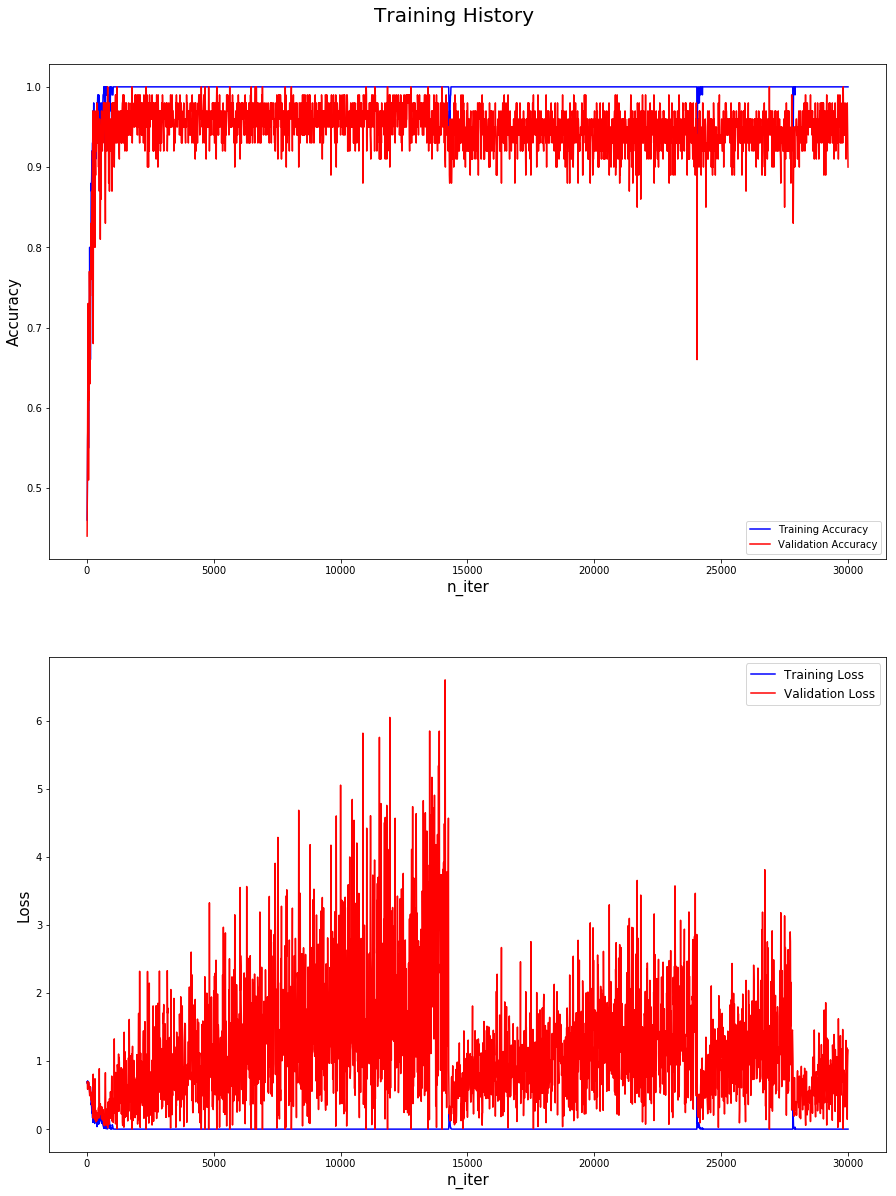

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_NX8H_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0115 22:15:17.463001 140204703008512 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 77.00 %    || 74.00 %    || 0.64302182 || 0.64371300
--------------------------------------------------------------
[*200] || 88.00 %    || 89.00 %    || 0.37484169 || 0.33076876
--------------------------------------------------------------
[*300] || 93.00 %    || 85.00 %    || 0.23749942 || 0.30450237
--------------------------------------------------------------
[*400] || 97.00 %    || 95.00 %    || 0.08403847 || 0.15571433
--------------------------------------------------------------
[*500] || 94.00 %    || 92.00 %    || 0.25208217 || 0.24066371
--------------------------------------------------------------
[*600] || 93.00 %    || 93.00 %    || 0.17477088 || 0.15037350
--------------------------------------------------------------
[*700] || 99.00 %    || 96.00 %    || 0.07070816 || 0.10232114
--------------------------------------------------------------
[*800] || 95.00 %    || 98.00 %    || 0.09345903 || 0.07381225
-------------------------------------------------------

[6600] || 98.00 %    || 99.00 %    || 0.03584110 || 0.04840082
--------------------------------------------------------------
[6700] || 100.00 %    || 100.00 %    || 0.00351637 || 0.00254969
--------------------------------------------------------------
[6800] || 99.00 %    || 100.00 %    || 0.02828946 || 0.00749078
--------------------------------------------------------------
[6900] || 100.00 %    || 98.00 %    || 0.00941352 || 0.02328370
--------------------------------------------------------------
[7000] || 100.00 %    || 99.00 %    || 0.01090745 || 0.03082992
--------------------------------------------------------------
[7100] || 99.00 %    || 99.00 %    || 0.01921898 || 0.03626637
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00082476 || 0.00599168
--------------------------------------------------------------
[7300] || 97.00 %    || 98.00 %    || 0.06951247 || 0.04131413
------------------------------------------------

[13100] || 99.00 %    || 100.00 %    || 0.02986396 || 0.00288019
--------------------------------------------------------------
[13200] || 100.00 %    || 99.00 %    || 0.00087523 || 0.01017267
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00019998 || 0.00722180
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00954269 || 0.00549441
--------------------------------------------------------------
[13500] || 100.00 %    || 100.00 %    || 0.00098689 || 0.00303050
--------------------------------------------------------------
[13600] || 100.00 %    || 98.00 %    || 0.00097582 || 0.04546976
--------------------------------------------------------------
[13700] || 100.00 %    || 99.00 %    || 0.00045122 || 0.01756913
--------------------------------------------------------------
[13800] || 100.00 %    || 100.00 %    || 0.00007137 || 0.00166918
-----------------------------------

[19500] || 100.00 %    || 99.00 %    || 0.00354533 || 0.01945477
--------------------------------------------------------------
[19600] || 100.00 %    || 99.00 %    || 0.00008634 || 0.00981811
--------------------------------------------------------------
[19700] || 100.00 %    || 100.00 %    || 0.00043005 || 0.00005919
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00083708 || 0.00014450
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00306318 || 0.00046890
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00087428 || 0.00053270
--------------------------------------------------------------
[20100] || 99.00 %    || 100.00 %    || 0.01381808 || 0.00008266
--------------------------------------------------------------
[20200] || 100.00 %    || 100.00 %    || 0.00083362 || 0.00067762
----------------------------------

[25900] || 100.00 %    || 100.00 %    || 0.00001218 || 0.00001459
--------------------------------------------------------------
[26000] || 100.00 %    || 100.00 %    || 0.00025604 || 0.00175023
--------------------------------------------------------------
[26100] || 100.00 %    || 100.00 %    || 0.00011430 || 0.00230004
--------------------------------------------------------------
[26200] || 100.00 %    || 100.00 %    || 0.00476263 || 0.00341651
--------------------------------------------------------------
[26300] || 100.00 %    || 100.00 %    || 0.00022458 || 0.00112438
--------------------------------------------------------------
[26400] || 100.00 %    || 100.00 %    || 0.00070787 || 0.00128278
--------------------------------------------------------------
[26500] || 100.00 %    || 100.00 %    || 0.00018254 || 0.00023136
--------------------------------------------------------------
[26600] || 100.00 %    || 100.00 %    || 0.00168842 || 0.00009475
-------------------------------

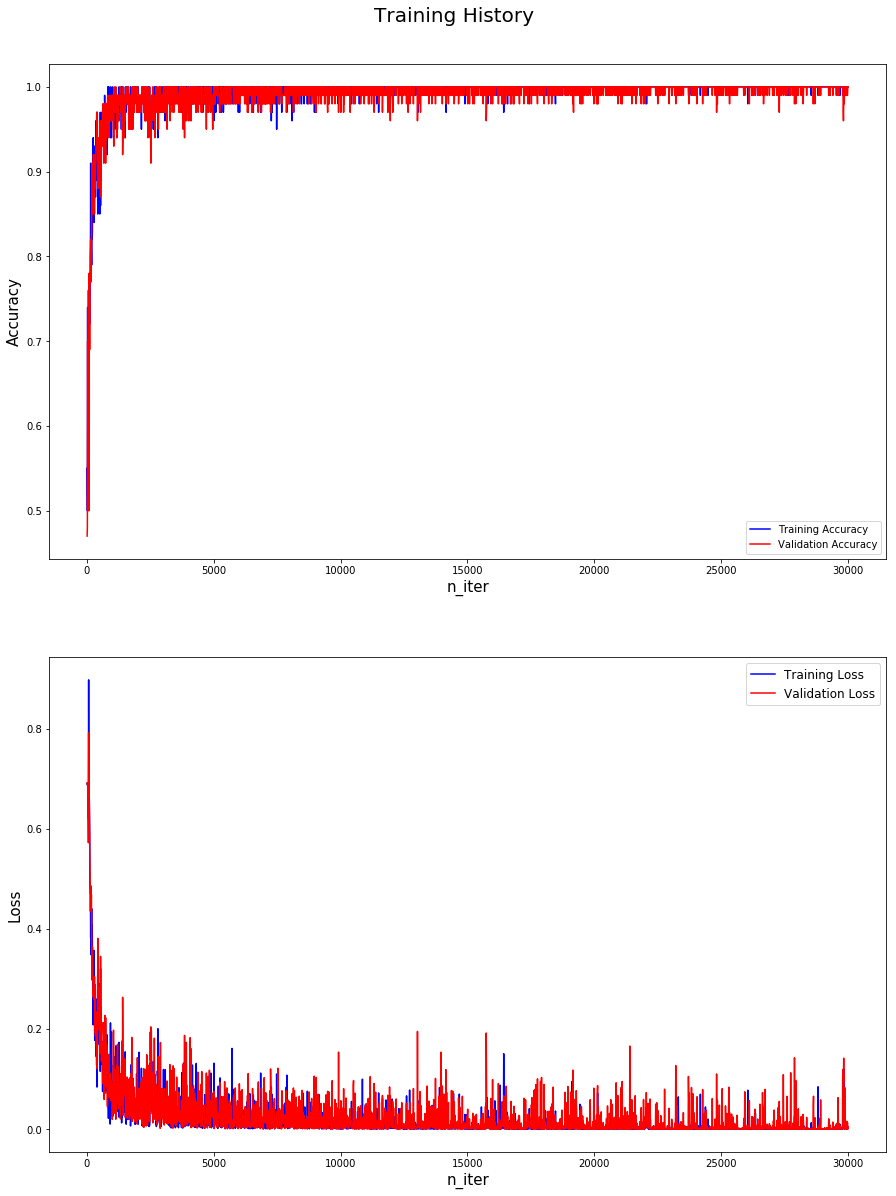

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_NX8H_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()